We start by importing all the libraries we are interested in.

In [2]:
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import gc                                 # What does this library do?
gc.enable()

# DARKS

Load in the darks. We had 6 from the night that we oberved (28/03). We also decided to use the darks from 25/03, of which there are 24.

In [29]:
directory = "C11_2022_03_28"
images = ccdproc.ImageFileCollection("./" + directory, glob_include = 'Dark_*')    # loads in all of the darks for 28/03
directory2 = "C11_2022_03_25"
images2 = ccdproc.ImageFileCollection("./" + directory2, glob_include = 'Dark_*')  # loads in all of the darks for 25/03

In [30]:
# make sure the files have been loaded
print(len(images.files))
print(len(images2.files))

6
24


Load in all of the dark filenames.

In [31]:
# loops through the filenames and reads the data for each file

# start with darks from 28/03
darks = [ CCDData.read(directory + '/' + fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 3) ]
# now add the darks from the 25/03
darks += [ CCDData.read(directory2 + '/' + fn, unit = "adu") for fn in images2.files_filtered(PICTTYPE = 3) ]

Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'.
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to  2896022.315 from OBSGEO-[LBH].
Set OBSGEO-Z to -3889419.901 from OBSGEO-[LBH]'.


We check that all of the darks have been included.

In [32]:
len(darks)

30

We start by checking some statistics of the first dark.

In [33]:
image = darks[0]

print('Exposure time:',image.header['EXPTIME'], 'seconds')

print('Min:', np.min(image))
print('Max:', np.max(image))
print('Median:', np.median(image))
print('Std Dev:', np.std(image))

Exposure time: 3600.0 seconds
Min: 2124
Max: 65535
Median: 2361.0
Std Dev: 676.9731415353291


The median of the bias image was 2079 counts. The mean of this dark image is slightly larger than that, which is expected as the dark will contain all of the electronics and detector noise as well as contributions from the dark current. The standard deviation is very large, which is due to the broad range of values - most pixels will have counts a little larger than the median value of the bias, but some hot pixels will have very high counts. Given that the maximum counts detected is 65535, some pixels are likely to be saturated due to dark current.

We now need to subtract the median-combined bias from the darks.

In [34]:
bias_median = CCDData.read('bias_median.fits', unit = 'adu')

for idx, thisimage in enumerate(darks): 
    darks[idx] = ccdproc.subtract_bias(thisimage, bias_median)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


We will examine the first image with the bias subtracted.

In [37]:
print('Min:', np.min(darks[0]))
print('Max:', np.max(darks[0]))
print('Median:', np.median(darks[0]))
print('Std Dev:', np.std(darks[0]))

Min: 40.5
Max: 63459.5
Median: 280.5
Std Dev: 676.7537573150946


These statistics look good - the median is 280.5 counts, which is roughly the difference between the counts of the image and the counts of the median combined bias image. The standard deviation is still large because we have just subtracted off the bias - there are still a lot of hot pixels that cause this large standard deviation.

In [38]:
dark_median = ccdproc.Combiner(darks, dtype=np.float32).median_combine() # median combine the dark images

In [40]:
print('Statistics for median-combined dark image')

print('Min:', np.min(dark_median))
print('Max:', np.max(dark_median))
print('Median:', np.median(dark_median))
print('Std Dev:', np.std(dark_median))



Statistics for median-combined dark image
Min: 66.5
Max: 63459.5
Median: 234.0
Std Dev: 673.67822265625


Again, these statitics look reasonable. The median of 234 counts for a 3600 second exposure seems reasonable. The standard deviation is still large because the hot pixels are in the same location in each image, so they remain in the combined image.

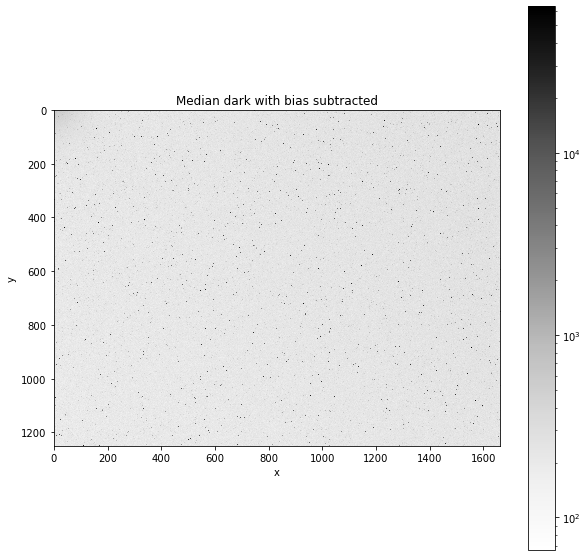

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
plt.imshow(dark_median, cmap = 'Greys', norm = LogNorm())
plt.title('Median dark with bias subtracted')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

This dark looks good - it is very uniform except for the hot pixels, which are much brighter than the other pixels.

In [47]:
dark_median.meta.update(EXPTIME = 3600)           # add exposure time to dark_median header
dark_median.meta.update(TELESCOP = 'C14')         # add telescope used
dark_median.meta.update(OBJECT = 'Dark_Median')   # add object name so we can identify the dark median image
dark_median.write("dark_median.fits")             # write the dark_median image to a fits file

In [48]:
del(darks)
collected = gc.collect()
print('Check garbage collection', collected)

Check garbage collection 25496
